[View in Colaboratory](https://colab.research.google.com/github/pilipolio/learn-pytorch/blob/master/201804_TSNE.ipynb)


# Stochastic neighbour embedding

 * http://lvdmaaten.github.io/tsne
 * [Original article](http://jmlr.csail.mit.edu/papers/volume9/vandermaaten08a/vandermaaten08a.pdf) and author [presentation video](https://www.youtube.com/watch?v=RJVL80Gg3lA)

Approximating a conditional probability distribution by learning embeddings $y_i$ of each data points
$$ p_{j|i} \approx q_{j|i} = \frac{ \exp ( - || y_i - y_j  ||^2) }{ \sum_{k\neq i} \exp ( - || y_i - y_k  ||^2) }$$
    

In [13]:
! pip install torch
import torch
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

torch.__version__

'0.4.0'

## Toy model

Transition probabilities between 3 states

In [216]:
n = 3
d = 2

points_to_clusters = [0, 1, 2]

p_ij = np.array([
    [.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

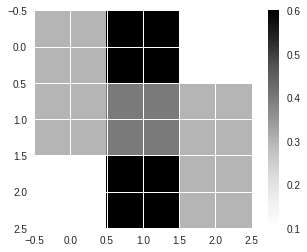

In [217]:
plt.imshow(p_ij, cmap='Greys')
plt.colorbar();

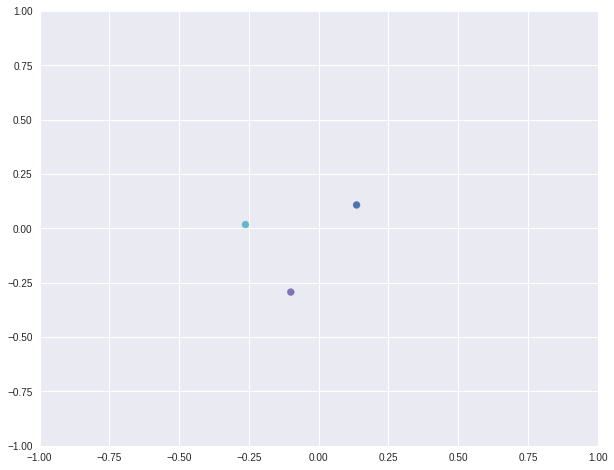

In [219]:
import seaborn as sns
from matplotlib.colors import ListedColormap

cmap = ListedColormap(sns.color_palette())
y_i = np.random.normal(scale=.25, size=(n, d))

def plot(y_i, points_to_clusters, ax=None, marker='o'):
    if ax is None:
        f, ax = plt.subplots(figsize=(10, 8))
    ax.scatter(*y_i.T, c=points_to_clusters, marker=marker, cmap=cmap)
    ax.set_xlim([-1, 1]); ax.set_ylim([-1, 1]);
    return ax

plot(y_i, points_to_clusters);

In [32]:
# Numpy broadcasting to perform cartesian product of nxn euclidean distances
# https://stackoverflow.com/a/37903795/230286

# (n x 1 x d) - (n x d) -> (n x n x d)
squared_distances_i_j_k = np.power(y_i[:, np.newaxis, :] - y_i, 2)
pairwise_squared_distances_i_j = squared_distances_i_j_k.sum(axis=2)

pairwise_squared_distances_i_j

array([[0.        , 0.16558579, 0.03631453],
       [0.16558579, 0.        , 0.04735956],
       [0.03631453, 0.04735956, 0.        ]])

In [33]:
unnormalized_q_i_j = np.exp(-pairwise_squared_distances_i_j)
q_i_j = unnormalized_q_i_j / unnormalized_q_i_j.sum(axis=1)

q_i_j

array([[0.35565241, 0.3025185 , 0.33046952],
       [0.30137884, 0.35699731, 0.32683956],
       [0.34296875, 0.34048419, 0.34269093]])

### Pytorch equivalent

In [34]:
import torch
import torch.autograd
from torch.autograd import Variable

In [35]:
def pairwise_squared_distances(y_i: torch.Tensor):
    # (n x 1 x d) - (n x d) -> (n x n x d)
    squared_distances_ijk = (y_i[:, None, :] - y_i) ** 2
    pairwise_squared_distances_ij = squared_distances_ijk.sum(2)    
    return pairwise_squared_distances_ij

pairwise_squared_distances(torch.from_numpy(y_i))

tensor([[ 0.0000,  0.1656,  0.0363],
        [ 0.1656,  0.0000,  0.0474],
        [ 0.0363,  0.0474,  0.0000]], dtype=torch.float64)

In [36]:
def approximated_probs(embeddings_i: torch.Tensor):
    pairwise_squared_distances_ij = pairwise_squared_distances(embeddings_i)
    unnormalized_q_ij = (-pairwise_squared_distances_ij).exp()
    q_ij = unnormalized_q_ij / unnormalized_q_ij.sum(1)

    return q_ij

approximated_probs(torch.from_numpy(y_i))

tensor([[ 0.3557,  0.3025,  0.3305],
        [ 0.3014,  0.3570,  0.3268],
        [ 0.3430,  0.3405,  0.3427]], dtype=torch.float64)

### Quick primer on [KL divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence)

 * roots in information theory (relative entropy)
 * "measures how one probability distribution diverges from a second distribution".
 * Well behaved cost function (differentiable) 
 * Not a distance because assymetric:

![title](https://image.slidesharecdn.com/vbtechtalk-150727192410-lva1-app6892/95/variational-inference-13-638.jpg?cb=1438030914)

### Back to the T-SNE cost function

KL divergence between $P_i$ and $Q_i$

Equation (3)

$$
\sum_i \text{KL} (P_i||Qi) = \sum_i \sum_j p_{j|i} \log \frac{p_{j|i}}{q_{j|i}}
$$

In [37]:
q_ij = approximated_probs(torch.from_numpy(y_i))
q_ij

tensor([[ 0.3557,  0.3025,  0.3305],
        [ 0.3014,  0.3570,  0.3268],
        [ 0.3430,  0.3405,  0.3427]], dtype=torch.float64)

In [38]:
def kl_divergence(p_ij: torch.Tensor, q_ij: torch.Tensor):
    return (p_ij * (q_ij.log() - p_ij.log())).sum()

kl = kl_divergence(torch.from_numpy(p_ij), q_ij)

kl

tensor(-0.4355, dtype=torch.float64)

## Gradient through loss back-propagation

array([[-0.14496794,  0.09547647],
       [ 0.09105835, -0.16273826],
       [ 0.00861008, -0.04710663]])

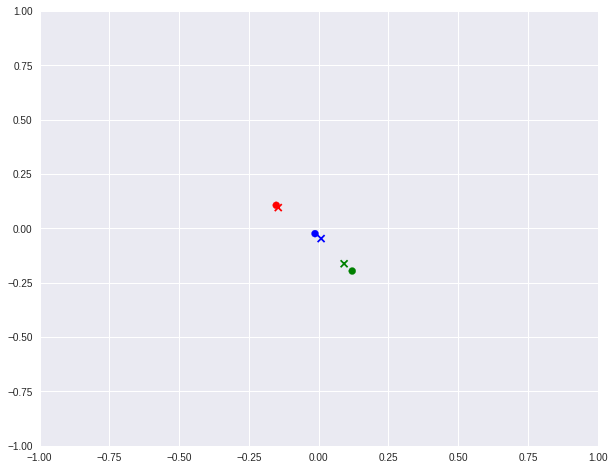

In [39]:
def updated_embeddings(current_y_i: np.array, p_ij: np.array, learning_rate=.2):
    embeddings_i = Variable(torch.from_numpy(current_y_i), requires_grad=True)
    
    loss = kl_divergence(torch.from_numpy(p_ij), q_ij=approximated_probs(embeddings_i))

    loss.backward()
    embeddings_gradient_i = embeddings_i.grad.data.numpy()

    return current_y_i + learning_rate * embeddings_gradient_i

updated_y_i = updated_embeddings(y_i, p_ij)

ax = plot(y_i, points_to_clusters)
plot(updated_y_i, points_to_clusters, ax, marker='x')

updated_y_i

## Illustration on a slightly more interesting dataset

$n$ individual data points spread accross 3 clusters, $p_ij$ depends on the cluster

In [40]:
inter_p_ij = np.array(
    [[.3, .6, .1],
     [.3, .4, .3],
     [.1, .6, .3]])

n = 75
points_to_clusters = np.repeat([0, 1, 2], repeats=25)

p_ij = np.vstack([
    np.repeat(inter_p_ij[0], repeats=25),
    np.repeat(inter_p_ij[1], repeats=25),
    np.repeat(inter_p_ij[2], repeats=25)])[points_to_clusters]

p_ij = p_ij / p_ij.sum(1)

points_to_clusters

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2])

In [68]:
y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i

print(p_ij.shape)
print(current_y_i.shape)

(75, 75)
(75, 2)


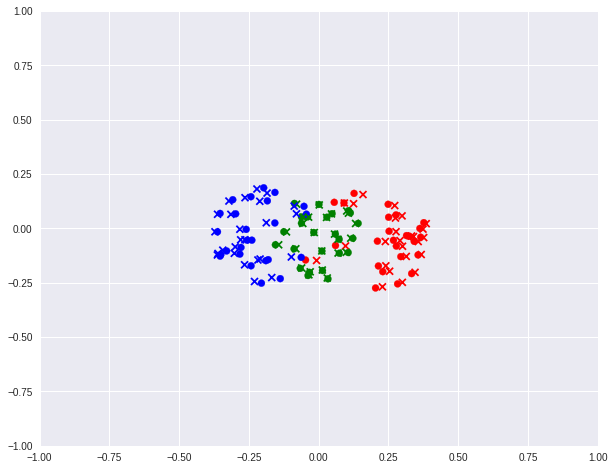

In [93]:
ax = plot(current_y_i, points_to_clusters)

updated_y_i = updated_embeddings(current_y_i, p_ij)

plot(updated_y_i, points_to_clusters, ax, marker='x')

current_y_i = updated_y_i 

## Real data set

In [10]:
! pip install lxml
import pandas as pd

tables = pd.read_html('https://distancecalculator.globefeed.com/UK_Distance_Calculator.asp', header=0)

In [323]:
cities = pd.read_csv('https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_name.txt', sep=',', skiprows=2, names=['city', 'state'])\
  .assign(state=lambda _:_.state.str.strip())\
  .assign(state_index=lambda _:_.state.astype('category').cat.codes)

cities.head(10)

,city,state,state_index
0,Youngstown,OH,30
1,Yankton,SD,37
2,Yakima,WA,42
3,Worcester,MA,16
4,Wisconsin Dells,WI,43
5,Winston-Salem,NC,24
6,Winnipeg,MB,17
7,Winchester,VA,40
8,Wilmington,NC,24
9,Wilmington,DE,7


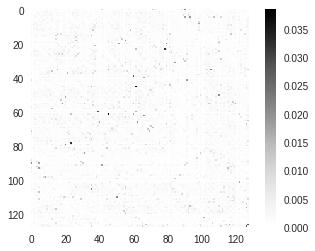

In [340]:
distances = pd.read_fwf('https://people.sc.fsu.edu/~jburkardt/datasets/cities/sgb128_dist.txt', skiprows=6).iloc[:, 1:]
distances.index = cities.city.values
distances.columns = cities.city.values

n = distances.shape[0]

similarities = 1 / (1 + distances.values) 
similarities[range(n), range(n)] = 0

p_ij = (similarities.T / similarities.sum(axis=0)).T

plt.imshow(similarities, cmap='Greys')
plt.colorbar();

In [429]:
points_to_clusters = cities.state_index.values

y_i = np.random.normal(scale=.25, size=(n, d))
current_y_i = y_i


print(p_ij.shape)
print(current_y_i.shape)

(128, 128)
(128, 2)


In [454]:
def plot_cities(embeddings, points_to_clusters):
  f, ax = plt.subplots(figsize=(12, 8))
  ax.scatter(*embeddings.T, c=points_to_clusters, marker='o', cmap=cmap)

  for name, xy in zip(cities.state.values, embeddings):
    ax.text(*xy, s=name)

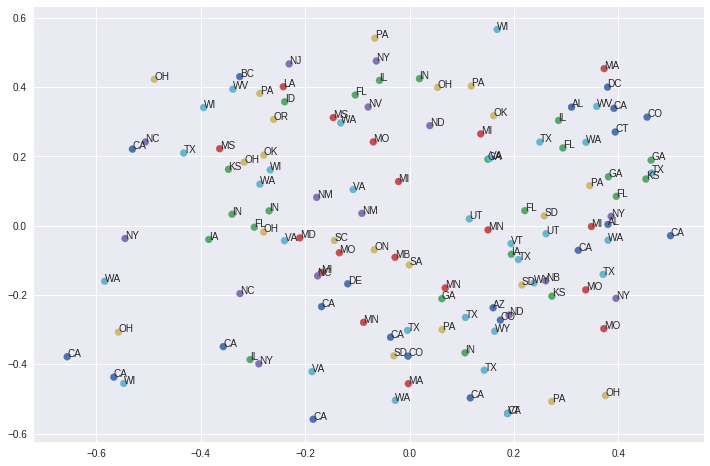

In [450]:
updated_y_i = updated_embeddings(current_y_i, p_ij, learning_rate=.5)

plot_cities(updated_y_i, points_to_clusters)

current_y_i = updated_y_i


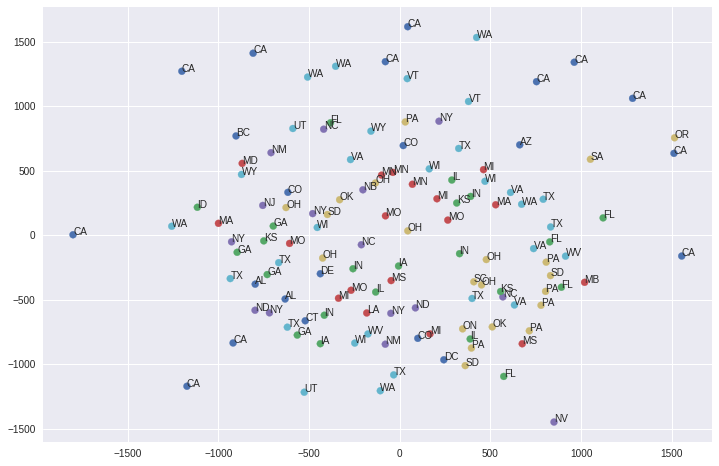

In [455]:
from sklearn import manifold

mds = manifold.MDS(dissimilarity='precomputed', n_components=2)

mds_embeddings = mds.fit_transform(distances)

plot_cities(mds_embeddings, points_to_clusters)


In [341]:
ca_cities = cities[cities.state == 'CA']

distances.iloc[ca_cities.index, ca_cities.index]

,Weed,Stockton,Santa Rosa,Santa Barbara,Santa Ana,San Jose,San Francisco,San Diego,San Bernardino,Salinas,Sacramento,Red Bluff
Weed,0,2295,3125,1265,2179,1825,1753,1398,1246,3022,2399,3166
Stockton,2295,0,3120,2655,1144,1787,2294,1760,1381,1812,1912,2015
Santa Rosa,3125,3120,0,1778,1160,3186,2189,2147,2563,2662,1883,656
Santa Barbara,1265,2655,1778,0,2441,1755,810,2149,2464,1663,1737,2658
Santa Ana,2179,1144,1160,2441,0,2632,1729,3019,2090,3004,2128,2908
San Jose,1825,1787,3186,1755,2632,0,2606,1250,2961,2936,2117,2798
San Francisco,1753,2294,2189,810,1729,2606,0,1751,1176,2880,2732,1761
San Diego,1398,1760,2147,2149,3019,1250,1751,0,2397,2781,858,2256
San Bernardino,1246,1381,2563,2464,2090,2961,1176,2397,0,2273,3067,2009
Salinas,3022,1812,2662,1663,3004,2936,2880,2781,2273,0,2751,2848


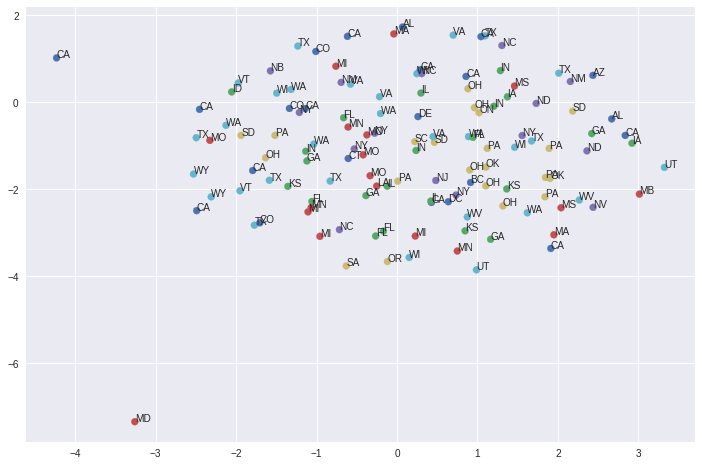

In [458]:
tsne = manifold.TSNE(metric='precomputed', n_components=2)

tsne_embeddings = tsne.fit_transform(distances)

plot_cities(tsne_embeddings, points_to_clusters)


In [457]:
manifold.TSNE?